### 학습 데이터 범위
* 1안 [현안]  
: {양호 , 불량부분(파손된 부분)} 학습

~~*2안~~  
~~:{양호, 불량전체(파손된 부분을 포함하는 객체 전체를 의미하는 듯함), 불량부분} 학습~~

~~*3안~~  
~~:{불량부분} 학습~~


### label

배경 0 

점자블럭 1 (파손부)

보도블럭 2 (파손부)

자전거도로 3 (파손부)

### format 변환

한 객체에 대한 Bound 를 나타내는 다각형의 점들의 집합  
**P = [(x1, y1), (x2, y2), ... (xn, yn)]**
**P_X = [x1, x2, ... , xn]**
**P_Y = [y1, y2, ... , yn]**

P -> P' 으로 사이즈 변환 및 좌표값 Normalizing 매핑을 위해서는,  

**(사이즈 변환에 의한 좌표 조정값) X (Normalizing Term)**  

x_ratio = (target_width / origin_width) * (1 / target_width) = 1 / origin_width  

y_ratio = (target_height / origin_height) * (1 / target_height) = 1 / origin_height  

P' = [(x1', y1'), (x2', y2'), ... (xn', yn')]

P_X' = [x1' , x2', ... xn'] = x_ratio x P_X

P_Y' = [y1', y2', ...yn'] = y_ratio x P_Y


x_min = minimum x coordinate in P'

x_max = maximum x coordinate in P'

y_min = minimum y coordinate in P'

y_max = maximum y coordinate in P'

최종적으로 다음의 포맷으로 변환하기 위한 관계식은

**class_id, center_x, center_y, width, height**

width = (x_max - x_min)

height = (y_max - y_min)

center_x = (x_min + x_max) / 2

center_y = (y_min + y_max) / 2

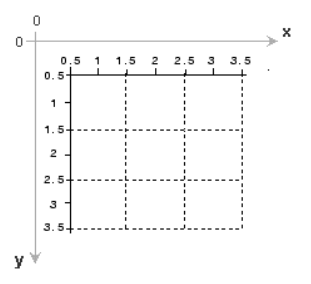  
이미지 좌표계  

### 함수 정의

In [ ]:
import json
import numpy as np
# from PIL import Image

# 단순히 사용 데이터셋의 .json 파일에서 필요한 정보를 추출하는 함수
def get_bounding_boxes_from(data : json):
    bounding_box_list = []
    labels = {
              "점자블럭" : 0,
              "보도블록" : 1,
              "자전거 도로" : 2,
              }
    # 분류할 타입
    # is_defect = ["정상", "불량부분"]
    is_defect = ["불량부분"]
    
    # labels
    for object in data["annotations"]:
        # is_defect 내에 포함되지 않으면 bounding box 를 생성하지 않음
        if not object["is_defect"] in is_defect: continue

        ## label info parsing ##

        encoded_label = 0 # default value
        try:
            label_name = object["label_name"]
            encoded_label = labels[label_name]
        except :
            print(f"잘못된 label_name : {label_name}")
            return
        
        ## bounding box parsing ##

        x_min = y_min = 9999
        x_max = y_max = 0
        for vertex in object["annotation_info"]:
            x = vertex[0]
            y = vertex[1]
            x_max = max(x, x_max)
            x_min = min(x, x_min)
            y_max = max(y, y_max)
            y_min = min(y, y_min)

        bounding_box_list.append([encoded_label, x_min, x_max, y_min, y_max])
        # print(bounding_box_list)
    
    bounding_boxes = np.array(bounding_box_list)
    
    return bounding_boxes


## 더이상 사용하지 않음 ##
# YOLO 모델의 .txt 라벨데이터 포맷에 맞게 Bounding box 정보 변환
# 정사각 이미지로 만들기 위해 padding 을 덧댄 경우
# def trans_format_with_padding(bounding_boxes : np.ndarray, json_file : json):
#     N_digits = 8
#     # class_id center_x center_y width height  
#     # 원본 이미지 사이즈
#     width, height = json_file["info"]["width"], json_file["info"]["height"]

#     long_edge = max(width, height)
#     short_edge = min(width, height)
    
#     padding = (long_edge - short_edge)/2
    
#     target_size = 640.0 # 축소할 사이즈
#     origin_size = long_edge # 패딩을 추가한 이미지는 long_edge X long_edge 의 사이즈가 된다.

#     # where fields are space delimited, and the coordinates are normalized from zero to one.
#     # Note: To convert to normalized xywh from pixel values, 
#     # divide x (and width) by the image's width and divide y (and height) by the image's height.
    
#     # (사이즈 변환에 의한 좌표 조정값) * (Normalizing Term)
#     # (target_size / origin_size) * (1 / target_size) = 1 / origin_size
#     ratio = round(1 / origin_size, ndigits=N_digits)

#     objects = []
#     for box in bounding_boxes:
#         label = box[0]
    
#         # width < heigth : 패딩이 x 축에만 추가
#         # width > height : 패딩은 y 축에만 추가
#         if (width < height) : 
#             x_min = ratio * (box[1] + padding) # x_min
#             x_max = ratio * (box[2] + padding) # x_max
#             y_min = ratio * box[3] # y_min
#             y_max = ratio * box[4] # y_max
#         else:
#             x_min = ratio * box[1] # x_min
#             x_max = ratio * box[2] # x_max
#             y_min = ratio * (box[3] + padding) # y_min
#             y_max = ratio * (box[4] + padding)# y_max

    
#         center_x = round((x_min + x_max)/2, ndigits=N_digits)
#         center_y = round((y_min + y_max)/2, ndigits=N_digits)
#         width = x_max - x_min
#         height = y_max - y_min
#         line = np.array([label, center_x, center_y, width, height])
#         objects.append(line)

#     return np.array(objects)

########################

def rotate_box(box : np.array, # [x_min, x_max, y_min, y_max]
               rotation_deg: float, # degrees
               rotation_center: tuple[float, float], # 회전중심
               ):
    
    cos_alpha = (np.cos(rotation_deg * np.pi / 180))
    sin_alpha = (np.sin(rotation_deg * np.pi / 180))

    x_min, x_max, y_min, y_max = box

    xo, yo = rotation_center

    # xo, yo 를 원점으로 하는 좌표계에서의 회전
    rotated_box = np.array([[cos_alpha*(x_min-xo) + sin_alpha*(y_min-yo), -sin_alpha*(x_min-xo) + cos_alpha*(y_min-yo)],
                            [cos_alpha*(x_min-xo) + sin_alpha*(y_max-yo), -sin_alpha*(x_min-xo) + cos_alpha*(y_max-yo)],
                            [cos_alpha*(x_max-xo) + sin_alpha*(y_min-yo), -sin_alpha*(x_max-xo) + cos_alpha*(y_min-yo)],
                            [cos_alpha*(x_max-xo) + sin_alpha*(y_max-yo), -sin_alpha*(x_max-xo) + cos_alpha*(y_max-yo)]])
    
    x_min = np.min(rotated_box[:, 0])
    x_max = np.max(rotated_box[:, 0])
    y_min = np.min(rotated_box[:, 1])
    y_max = np.max(rotated_box[:, 1])

    # 다시 (0,0) 을 원점으로 하는 원래 좌표계로 변환
    result = np.array([x_min+xo, x_max+xo, y_min+yo, y_max+yo])
    return result

# 패딩을 덧대지 않은 경우
# 정사각형 사이즈 이미지가 아니기 때문에 좌표 변환 과정이 살짝 다르다.
# 좌표를 표준화 하며, 이미지 너비 높이 비율은 유지
def trans_format_without_padding(bounding_boxes : np.ndarray, # class_id center_x center_y width height  
                                 json_file : json,
                                 rotation_deg : float = 0): # counter-clockwise rotation
    N_digits = 6

    # 원본 이미지 사이즈
    original_width, original_height = json_file["info"]["width"], json_file["info"]["height"]

    rad_deg = rotation_deg * np.pi/180

    # calcultate the width and height of rotated image
    # PIL 에서 rotate 할 때 expanded=True 로 설정하면 회전된 이미지 사이즈는 올림처리하여 정수로 표현됨
    new_width = np.ceil(np.abs(original_width * np.cos(rad_deg)) + np.abs(original_height * np.sin(rad_deg)))
    new_height = np.ceil(np.abs(original_width * np.sin(rad_deg)) + np.abs(original_height * np.cos(rad_deg)))
    xo = original_width/2
    yo = original_height/2
    rotation_center = (xo, yo)

    # the coordinates are normalized from zero to one.
    # divide x (width coordinate) by the image's width and divide y (height coordinate) by the image's height.
    # (사이즈 변환에 의한 좌표 조정값) * (Normalizing Term)
    # (target_width / width) * (1 / target_width) = 1 / width
    x_ratio = 1 / new_width
    y_ratio = 1 / new_height


    objects = []
    for box in bounding_boxes:
        label = box[0]

        xmin, xmax, ymin, ymax = box[1:]
        
        # counter-clockwise rotation
        # rotation_center 를 원점으로 하는 좌표계에서의 회전
        xmin, xmax, ymin, ymax = rotate_box(np.array([xmin, xmax, ymin, ymax]), 
                                                rotation_deg,
                                                rotation_center)

        # PIL rotate 에서 expand = True 인 경우
        # 이미지가 회전하여 원본 크기에서 벗어날 경우 확장시킨다.
        # Coordinate correction due to image expansion
        xmin += (new_width - original_width)/2
        xmax += (new_width - original_width)/2
        ymin += (new_height - original_height)/2
        ymax += (new_height - original_height)/2
        
        # normarlize image coordinates
        xmin = xmin * x_ratio
        xmax = xmax * x_ratio
        ymin = ymin * y_ratio
        ymax = ymax * y_ratio

        # 소수점 오차로 인해 미세하게 이미지 크기를 벗어날 경우 조정 (clipping)
        xmin = 0.0 if xmin < 0 else xmin
        xmax = 1.0 if xmax > 1 else xmax
        ymin = 0.0 if ymin < 0 else ymin
        ymax = 1.0 if ymax > 1 else ymax

        # 경계를 벗어난 바운딩 박스 모니터링 - 테스트 코드
        # if (xmin < 0 or xmax > 1 or ymin < 0 or ymax > 1):
        #     print("Invalid bounding box : ", json_file['info']['filename'])
        #     print((new_width, new_height))
        #     print([xmin, xmax, ymin, ymax])
        
        # print(x_min, x_max, y_min, y_max)
            
        center_x = (xmin + xmax)/2
        center_y = (ymin + ymax)/2
        width = xmax - xmin
        height = ymax - ymin
        # 소수점이하 N 번째 버림
        width = np.trunc(width * 10**N_digits) / 10**N_digits
        height = np.trunc(height * 10**N_digits) / 10**N_digits

        line = np.array([label, center_x, center_y, width, height])
        # 회전 후 bbox 가 느슨해지는 문제가 있음을 알고는 있어야 한다.
        objects.append(line)

    return np.array(objects)

bbox 테스트를 위한 시각화 코드

In [ ]:
import cv2
import matplotlib.pyplot as plt

def visualize_bbox(image, bboxes, rgb: tuple = (0, 255, 0), thickness : int = 3):
    for bbox in bboxes:
        class_type = bbox[0]
        xcenter, ycenter, width, height = bbox[1:]
        xmin, xmax = xcenter - width/2, xcenter + width/2
        ymin, ymax = ycenter - height/2, ycenter + height/2
        
        h, w, _ = image.shape
        pt1 =  np.int16(np.ceil([xmin * w, ymin * h]))
        pt2 = np.int16(np.ceil([xmax * w, ymax * h]))

        image = cv2.rectangle(image, pt1, pt2, rgb, thickness)

    plt.figure()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)

테스트 코드

D:/Downloads/street-facilities-selected/images/3_12_1_1_2_2_20211108_0001051465.jpg
bounding boxes
[1.00000000e+00 5.94305829e+02 2.26224000e+03 3.91680000e+02
 4.02624000e+03]
[1.00000000e+00 9.98893714e+01 6.74792229e+02 1.38816000e+03
 1.95264000e+03]
[1.00000000e+00 1.36539429e+01 7.03537371e+02 1.05984000e+03
 1.37664000e+03]


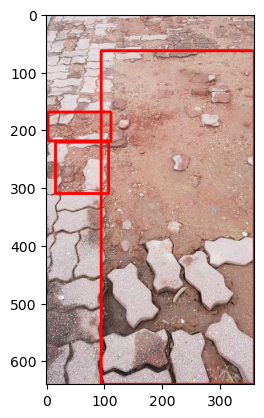

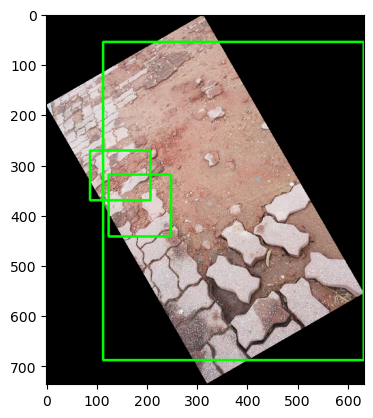

In [4]:
### test code ###
from PIL import Image

# apple
# 2_09_1_1_1_1_20210719_0000006002.jpg
# samsung
# 2_09_1_1_1_1_20210716_0000037039.jpg

root_path = "D:/Downloads/street-facilities-selected"

# empty list [] 반환
# file = "2_09_0_1_4_1_20210927_0000569294" # 정상

file = "3_12_1_1_2_2_20211108_0001051465"

image_path = f"{root_path}/images/{file}.jpg" # .jpg or .jpeg
json_path = f"{root_path}/labels/{file}.json"

with open(json_path, "r", encoding="utf-8") as f:
    data = json.load(f)

print(image_path)

bounding_boxes = get_bounding_boxes_from(data)

print("bounding boxes")
for box in bounding_boxes:
    print(box)

image = Image.open(image_path)

translated_format = trans_format_without_padding(bounding_boxes, data)
visualize_bbox(np.array(image), translated_format, (255, 0, 0))

rotated_image = image.rotate(30, center=(image.width / 2, image.height / 2), expand=True)
translated_format = trans_format_without_padding(bounding_boxes, data, 30)
visualize_bbox(np.array(rotated_image), translated_format)

이미지 범위를 벗어나는 바운딩 박스 존재 확인

In [5]:
import os
import json
import numpy as np

root_path = "D:/Downloads/street-facilities-selected"
json_path = f"{root_path}/labels"
save_path = "D:/Downloads/street-facilities-selected/labels-txt"

json_files = [f for f in os.listdir(json_path) if f.endswith('.json')]

total = len(json_files)

for i, filename in enumerate(json_files):
    if(i%1000==0):
        print(f"{i+1} / {total}")
        
    filename = os.path.splitext(filename)[0] # .json 확장자명 제거
    # status = int(filename.split("_")[2]) # 0 : 정상 1 : 불량
    # class_id = int(filename.split("_")[1]) # 09 점자블록, 12 보도블록, 13 자전거도로

    with open(f"{json_path}/{filename}.json", "r", encoding="utf-8") as f:
        data = json.load(f)
        width, height = data["info"]["width"], data["info"]["height"]
        bounding_boxes = get_bounding_boxes_from(data)

        translated_format = trans_format_without_padding(bounding_boxes, data)
        for normalized_box in translated_format:
            xcenter, ycenter, width, height = normalized_box[1:]
            if (xcenter + width / 2 > 1 
                or xcenter - width / 2 < 0
                or ycenter + height / 2 > 1
                or ycenter - height / 2 < 0):
                print("Invalid format")
                print(filename)
                print(normalized_box)

1 / 8477
1001 / 8477
2001 / 8477
3001 / 8477
4001 / 8477
5001 / 8477
6001 / 8477
7001 / 8477
8001 / 8477


### 변환

In [7]:
import os
import json
import numpy as np

root_path = "D:/Downloads/street-facilities-selected"
json_path = f"{root_path}/labels"
save_path = "D:/Downloads/street-facilities-selected/labels-txt"

os.makedirs(save_path, exist_ok=True)

json_files = [f for f in os.listdir(json_path) if f.endswith('.json')]

total = len(json_files)

print(json_path)

# 폴더에 있는 .json 파일 순회
for i, filename in enumerate(json_files):
    if(i%300==0):
        print(f"{i+1} / {total}")
        
    filename = os.path.splitext(filename)[0] # .json 확장자명 제거
    status = int(filename.split("_")[2]) # 0 : 정상 1 : 불량
    class_id = int(filename.split("_")[1]) # 09 점자블록, 12 보도블록, 13 자전거도로

    with open(f"{json_path}/{filename}.json", "r", encoding="utf-8") as f:
        data = json.load(f)
        bounding_boxes = get_bounding_boxes_from(data)
        # translated_format = trans_format_with_padding(bounding_boxes, data)
        translated_format = trans_format_without_padding(bounding_boxes, data)
        np.savetxt(f"{save_path}/{filename}.txt", translated_format, delimiter=" ", fmt='%.8f')

D:/Downloads/street-facilities-selected/labels
1 / 8477
301 / 8477
601 / 8477
901 / 8477
1201 / 8477
1501 / 8477
1801 / 8477
2101 / 8477
2401 / 8477
2701 / 8477
3001 / 8477
3301 / 8477
3601 / 8477
3901 / 8477
4201 / 8477
4501 / 8477
4801 / 8477
5101 / 8477
5401 / 8477
5701 / 8477
6001 / 8477
6301 / 8477
6601 / 8477
6901 / 8477
7201 / 8477
7501 / 8477
7801 / 8477
8101 / 8477
8401 / 8477


### 필수 ###
classId 는 Int 형이여야 하므로 이에 대한 처리 수행

In [8]:
import os

root_path = "D:/Downloads/street-facilities-selected"

label_path = f"{root_path}/labels-txt"

labels = [label for label in os.listdir(label_path) if label.endswith('.txt')]
total_cnt = len(labels)

for i, label in enumerate(labels):
    if i % 1000 == 0 :
        print(f"{i+1} / {total_cnt}")
    annotations = []
    with open(os.path.join(label_path, label), "r+", encoding="utf-8") as f:
        # 기존 내용 읽기 및 수정
        for line in f:
            elems = line.split(" ")
            elems[0] = str(int(float(elems[0]))) # 1.00000000 -> 1 -> '1'
            newline = " ".join(elems)
            annotations.append(newline)
            
        # 새 내용 작성
        f.seek(0) # 파일 포인터 이동
        for annotation in annotations:
            f.write(annotation)
        f.truncate() # 파일 포인터 이전 내용만 남기고 나머지 삭제

1 / 8477
1001 / 8477
2001 / 8477
3001 / 8477
4001 / 8477
5001 / 8477
6001 / 8477
7001 / 8477
8001 / 8477
